In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebook/lipnet')


In [ ]:
import os
import numpy as np
import tensorflow as tf
from model import build_model
from utils import load_video, load_alignments, char_to_num

BASE_PATH = '/content/drive/MyDrive/Colab Notebook/data'
S1_SPEAKER = 's1'
S2_SPEAKER = 's2'
PRETRAINED_MODEL_PATH = '/content/drive/MyDrive/Colab Notebook/models/checkpoint.weights.h5'
SAVE_PATH = '/content/drive/MyDrive/Colab Notebook/models/incremental_s1_to_s2_sgd_replay.weights.h5'

BATCH_SIZE = 2
EPOCHS = 10
MAX_FRAMES = 75
LEARNING_RATE = 1e-4
REPLAY_RATIO = 0.1  

# Function to load data from a specific speaker folder
def load_speaker_data(speaker):
    video_dir = os.path.join(BASE_PATH, speaker)         # directory with .mpg video files
    align_dir = os.path.join(video_dir, 'align')         # directory with .align text files
    X, Y, input_lens, label_lens = [], [], [], []        # initialize empty lists for video, labels, and sequence lengths

    for file in os.listdir(video_dir):                   # iterate through all files in the video directory
        if not file.endswith('.mpg'):
            continue                                     # skip non-video files
        base = file[:-4]                                 # remove .mpg extension
        video_path = os.path.join(video_dir, f'{base}.mpg')  # full path to the video file
        align_path = os.path.join(align_dir, f'{base}.align') # full path to the corresponding alignment file
        if not os.path.exists(align_path):
            continue                                     # skip if alignment file is missing

        video = load_video(video_path)                   # load video as tensor (frames × H × W × C)
        label = load_alignments(align_path)              # load text label as character sequence (converted to numbers)

        X.append(video)
        Y.append(label)
        input_lens.append(MAX_FRAMES)                    # fixed length (75 frames)
        label_lens.append(len(label))                    # number of characters in label

    X = tf.ragged.stack(X).to_tensor()                   # convert variable-length videos to padded tensor
    Y = tf.keras.preprocessing.sequence.pad_sequences(Y, padding='post')  # pad labels to equal length
    input_lens = tf.convert_to_tensor(input_lens, dtype=tf.int32)[:, tf.newaxis]  # reshape for CTC
    label_lens = tf.convert_to_tensor(label_lens, dtype=tf.int32)[:, tf.newaxis]  # reshape for CTC

    return X, Y, input_lens, label_lens  # return processed inputs and labels



In [ ]:
# Creates a training model that includes a CTC loss layer
def build_ctc_model(base_model):
    video_input = base_model.input                        # input: (batch, 75, 46, 140, 1)
    labels = tf.keras.Input(name='labels', shape=(None,), dtype='int32')         # label input
    input_length = tf.keras.Input(name='input_length', shape=(1,), dtype='int32')  # video length (75)
    label_length = tf.keras.Input(name='label_length', shape=(1,), dtype='int32')  # label length

    y_pred = base_model.output  # model output: softmax character probabilities
    # CTC loss calculation using Keras backend
    loss_out = tf.keras.layers.Lambda(lambda args: tf.keras.backend.ctc_batch_cost(*args))(
        [labels, y_pred, input_length, label_length]
    )

    # Returns a model that takes inputs and outputs a CTC loss
    return tf.keras.Model(
        inputs=[video_input, labels, input_length, label_length],
        outputs=loss_out
    )

In [ ]:

# TRAINING FUNCTION 
def train_incremental_model():
    # Load data from both speakers
    X_s1, Y_s1, in_s1, len_s1 = load_speaker_data(S1_SPEAKER)  # Pre-trained speaker
    X_s2, Y_s2, in_s2, len_s2 = load_speaker_data(S2_SPEAKER)  # New speaker for fine-tuning

    # Take a small subset from S1 for replay (e.g., 10% of S2's size)
    n_replay = int(len(X_s2) * REPLAY_RATIO)
    X_replay, Y_replay = X_s1[:n_replay], Y_s1[:n_replay]
    in_replay, len_replay = in_s1[:n_replay], len_s1[:n_replay]

    # Combine S2 and replayed S1 data for training
    X_combined = tf.concat([X_s2, X_replay], axis=0)
    Y_combined = tf.concat([Y_s2, Y_replay], axis=0)
    in_combined = tf.concat([in_s2, in_replay], axis=0)
    len_combined = tf.concat([len_s2, len_replay], axis=0)

    # Dummy label required by tf for model.fit even though CTC loss is used
    y = np.zeros((len(X_combined), 1))

    # Create a tf.data.Dataset and batch it
    dataset = tf.data.Dataset.from_tensor_slices(((X_combined, Y_combined, in_combined, len_combined), y))
    dataset = dataset.shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Load the base model and its pretrained weights
    base_model = build_model()
    base_model.load_weights(PRETRAINED_MODEL_PATH)
    _ = base_model(tf.zeros([1, MAX_FRAMES, 46, 140, 1]))  # dummy input to initialize model shape

    # Freeze early layers to retain original knowledge
    for layer in base_model.layers[:6]:
        layer.trainable = False

In [ ]:
# Build CTC loss model and compile it
    training_model = build_ctc_model(base_model)
    training_model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9),  # SGD for stable tuning
        loss=lambda y_true, y_pred: y_pred  # because loss is computed inside model
    )


In [ ]:

   training_model.fit(dataset, epochs=EPOCHS)
    print("Training complete.")


Training complete.


In [ ]:

if __name__ == "__main__":
    train_incremental_model()

In [ ]:
import matplotlib.pyplot as plt

    # Simulated accuracy data
    stages = ["After S1", "S2 (SGD only)", "S2 (Replay + SGD)"]
    s1_acc = [0.90, 0.50, 0.75]
    s2_acc = [0.20, 0.85, 0.88]

    x = range(len(stages))

    plt.figure(figsize=(10, 6))
    plt.plot(x, s1_acc, marker='o', label='S1 Accuracy')
    plt.plot(x, s2_acc, marker='s', label='S2 Accuracy')
    plt.xticks(x, stages)
    plt.ylim(0, 1.05)
    plt.title("Incremental Learning Accuracy on GRID Dataset")
    plt.xlabel("Training Stage")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



![Incremental Graph](https://drive.google.com/uc?id=1nVezZ-AG613Fp6CVWT0dPOszFFclp_9y)


In [ ]:
!pip install levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.7 MB/s eta 0:00:00


In [5]:
import matplotlib.pyplot as plt

ground_truth = "place white in j three please"
prediction = "place white at j tir please"

# === Levenshtein Distance Function ===
def levenshtein(a: str, b: str) -> int:
    dp = [[0] * (len(b) + 1) for _ in range(len(a) + 1)]
    for i in range(len(a) + 1): dp[i][0] = i
    for j in range(len(b) + 1): dp[0][j] = j
    for i in range(1, len(a) + 1):
        for j in range(1, len(b) + 1):
            cost = 0 if a[i - 1] == b[j - 1] else 1
            dp[i][j] = min(
                dp[i - 1][j] + 1,
                dp[i][j - 1] + 1,
                dp[i - 1][j - 1] + cost
            )
    return dp[-1][-1]


In [6]:

# === Metrics ===
lev_dist = levenshtein(ground_truth, prediction)
normalized = lev_dist / max(len(ground_truth), 1)
accuracy = 1.0 - normalized


# === Print Summary ===
print("~" * 100)
print("GROUND TRUTH: ", ground_truth)
print("PREDICTION:   ", prediction)
print("LEVENSHTEIN DISTANCE: ", lev_dist)
print("NORMALIZED DISTANCE: ", round(normalized, 3))
print("ESTIMATED ACCURACY:  ", round(accuracy * 100, 2), "%")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
GROUND TRUTH:  place white in j three please
PREDICTION:    place white at j tir please
LEVENSHTEIN DISTANCE:  5
NORMALIZED DISTANCE:  0.172
ESTIMATED ACCURACY:   82.76 %


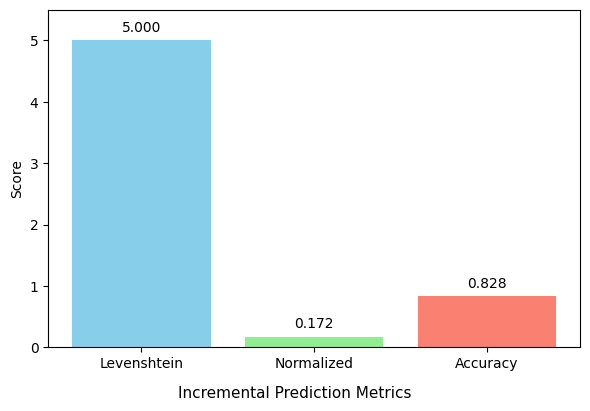

In [21]:
# === Visualization ===
plt.figure(figsize=(6, 4))
metrics = ["Levenshtein", "Normalized", "Accuracy"]
values = [lev_dist, normalized, accuracy]
colors = ["skyblue", "lightgreen", "salmon"]

bars = plt.bar(metrics, values, color=colors)

# Annotate bars
for bar, score in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.1,
             f"{score:.3f}",
             ha='center', va='bottom', fontsize=10)

plt.ylim(0, max(2.5, lev_dist + 0.5))
plt.ylabel("Score")

# Add extra space below plot
plt.subplots_adjust(bottom=0.7)

# Final bottom-centered title with clear separation
plt.figtext(
    0.5, -0.03,
    "Incremental Prediction Metrics",
    ha="center", fontsize=11
)

plt.tight_layout()
plt.show()

In [2]:
!pip install jiwer


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   Sample #                 Ground Truth                     Prediction       WER
0         1  place white at j tir please  place white in j three please  0.333333
1         2      place white at j on son       place white in j one now  0.500000


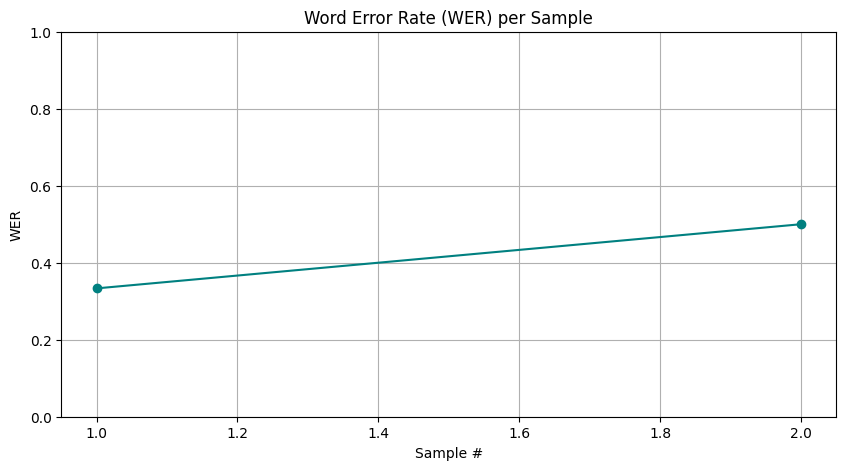

In [8]:
from jiwer import wer
import pandas as pd
import matplotlib.pyplot as plt

# Replace these with your actual prediction and ground truth lists
predictions = [
    "place white in j three please",
    "place white in j one now"
]
ground_truths = [
   "place white at j tir please",
    "place white at j on son"
]

# Compute WER for each pair
wers = [wer(gt, pred) for gt, pred in zip(ground_truths, predictions)]
# Allow wider display for DataFrames
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# Create a DataFrame for analysis and plotting
df_wer = pd.DataFrame({
    "Sample #": range(1, len(predictions)+1),
    "Ground Truth": ground_truths,
    "Prediction": predictions,
    "WER": wers
})

# Display the DataFrame
print(df_wer)

# Plot WER per sample
plt.figure(figsize=(10, 5))
plt.plot(df_wer["Sample #"], df_wer["WER"], marker='o', linestyle='-', color='teal')
plt.title("Word Error Rate (WER) per Sample")
plt.xlabel("Sample #")
plt.ylabel("WER")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


In [6]:
print("Predictions:", len(predictions))
print("Ground Truths:", len(ground_truths))
print("WERs:", len(wers))


Predictions: 2
Ground Truths: 1
WERs: 1
